In [19]:
import numpy as np

In [3]:
%pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 22.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 20.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 11.0 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp38-cp38-macosx_10_9_x86_64.whl (192 kB)
  Using cached filelock-3.12.0-py3-none-any.whl (10 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 MB 9.1 MB/s eta 0:00:0000:0100:01
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


### Preparing the classification model from Huggingface

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

/opt/anaconda3/envs/amd_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest")

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest")

In [47]:
from scipy.special import softmax

hate_text = "osama spin laden droppin' beats like the twin towers. I will kill you. You will be killed immediately! "
nonhate_text = "is it ok for your son or daughter to call another man \"daddy?"


def predict_hate(model, hate_text):
    print("X")
    encoded_input = tokenizer(hate_text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return {"non_hate": np.round(float(scores[ranking[0]]), 4), "hate": np.round(float(scores[ranking[1]]), 4)}

predict_hate(model, hate_text=nonhate_text)


X


{'non_hate': 0.9121, 'hate': 0.0879}

### Investigating whether the hate scores are capturing the pattern from the text

In [40]:
import pandas as pd

In [41]:
TRAIN_PATH = 'data_preprocessed/train_embedding.csv'
EVAL_PATH = 'data_preprocessed/eval_embedding.csv'
TEST_PATH = 'data_preprocessed/test_embedding.csv'

In [42]:
train_df = pd.read_csv(TRAIN_PATH)
eval_df = pd.read_csv(EVAL_PATH)
test_df = pd.read_csv(TEST_PATH)

In [43]:
train_df.head()

,id,img,label,text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,42953,img/42953.png,0,its their character not their color that matters,-0.047270,0.081864,0.032437,-0.151744,0.049869,0.274994,...,-0.048635,-0.003773,0.056420,0.018093,-0.000858,-0.126719,0.038306,0.173042,-0.080767,-0.104416
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,-0.044260,0.081599,0.024389,-0.146163,0.046460,0.255240,...,-0.047174,0.003364,0.052712,0.018431,0.001211,-0.129407,0.036726,0.171141,-0.089248,-0.101055
2,13894,img/13894.png,0,putting bows on your pet,-0.052200,0.073329,0.021844,-0.134351,0.040769,0.272686,...,-0.045449,-0.020424,0.046338,0.003759,-0.008393,-0.137328,0.047681,0.180136,-0.073047,-0.107347
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,-0.045982,0.080845,0.045772,-0.142562,0.057844,0.263742,...,-0.054534,0.001266,0.029108,0.038134,0.001083,-0.127383,0.049963,0.161953,-0.076331,-0.104860
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",-0.045905,0.074049,0.047349,-0.165169,0.053242,0.253701,...,-0.042046,0.025660,0.017383,0.065593,0.040692,-0.127206,0.060397,0.129530,-0.067772,-0.088842


In [48]:
train_df["hate_score"] = [predict_hate(model, hate_text=t)["hate"] for t in train_df["text"]]
# train_df["nonhate_score"] = [predict_hate(model, hate_text=t)["non_hate"] for t in train_df["text"]]

X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X


In [49]:
train_df.head()

,id,img,label,text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,hate_score
0,42953,img/42953.png,0,its their character not their color that matters,-0.047270,0.081864,0.032437,-0.151744,0.049869,0.274994,...,-0.003773,0.056420,0.018093,-0.000858,-0.126719,0.038306,0.173042,-0.080767,-0.104416,0.0121
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,-0.044260,0.081599,0.024389,-0.146163,0.046460,0.255240,...,0.003364,0.052712,0.018431,0.001211,-0.129407,0.036726,0.171141,-0.089248,-0.101055,0.0020
2,13894,img/13894.png,0,putting bows on your pet,-0.052200,0.073329,0.021844,-0.134351,0.040769,0.272686,...,-0.020424,0.046338,0.003759,-0.008393,-0.137328,0.047681,0.180136,-0.073047,-0.107347,0.0032
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,-0.045982,0.080845,0.045772,-0.142562,0.057844,0.263742,...,0.001266,0.029108,0.038134,0.001083,-0.127383,0.049963,0.161953,-0.076331,-0.104860,0.0093
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",-0.045905,0.074049,0.047349,-0.165169,0.053242,0.253701,...,0.025660,0.017383,0.065593,0.040692,-0.127206,0.060397,0.129530,-0.067772,-0.088842,0.0019


### Analyzing the Hate Score

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

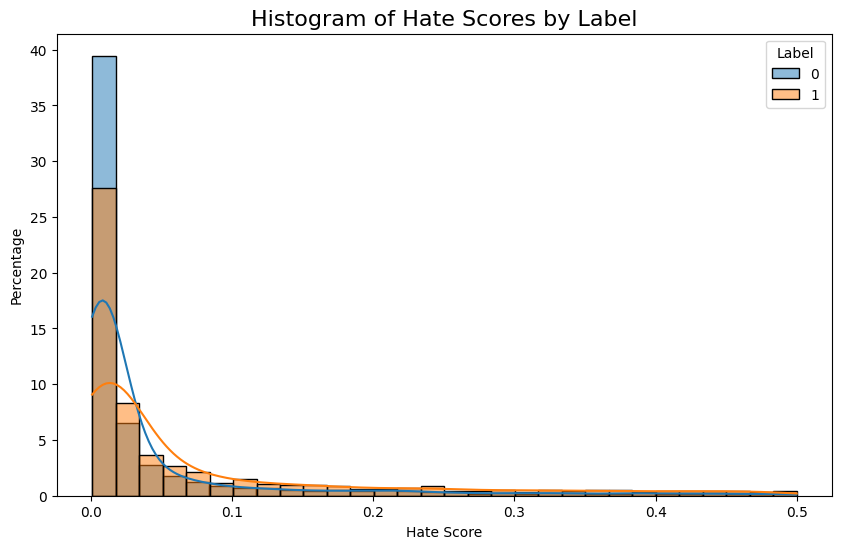

In [59]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a histogram or KDE plot for each label
for label in train_df['label'].unique():
    subset = train_df[train_df['label'] == label]
    sns.histplot(subset['hate_score'], bins=30, label=label, kde=True, stat='density', ax=ax)

# Add a title
ax.set_title('Histogram of Hate Scores by Label', fontsize=16)

# Add labels
ax.set_xlabel('Hate Score')
ax.set_ylabel('Percentage')

# Add a legend
ax.legend(title='Label')

# Show the plot
plt.show()

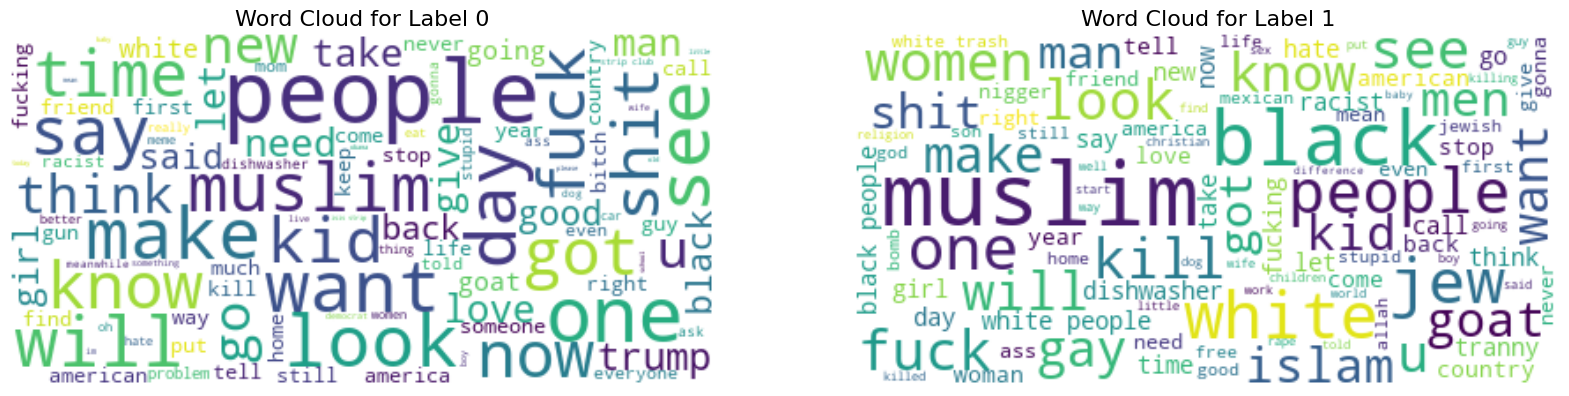

In [62]:
from wordcloud import WordCloud

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Create a word cloud for each label
for i, label in enumerate(train_df['label'].unique()):
    # Select the subset of the DataFrame for this label
    subset = train_df[train_df['label'] == label]
    
    # Join all the text into one string
    text = ' '.join(subset['text'])
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

    # Display the generated image
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Word Cloud for Label {label}', fontsize=16)
    axs[i].axis('off')

# Show the plot
plt.show()

**As we compare the word clouds for hateful and non-hateful memes, we see some distinct words like "kill", "white", "women", "goat" in memes with hateful label.**